<a href="https://colab.research.google.com/github/anshika-pathakk/ML-Lab_Experiments/blob/main/Exp7/k_means.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Experiment 7 — Implementing K-Means Clustering from Scratch

### Objective

The goal of this assignment is to implement the K-Means clustering algorithm from scratch using NumPy, apply it to a customer segmentation dataset, and interpret the clusters formed.


### 1. Introduction

K-means clustering is an unsupervised machine learning algorithm used to partition a dataset into a predefined number of clusters, denoted by 'K'. This algorithm is particularly useful for discovering inherent groupings within unlabeled data, where no prior knowledge of class labels exists.

The core idea behind K-means is to minimize the within-cluster variance, aiming to make data points within the same cluster as similar as possible, while maximizing the dissimilarity between points in different clusters. It achieves this by iteratively refining the position of cluster centroids, which represent the center of each cluster.


### 2. Importing Libraries and Dataset


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans as SKKMeans

## Dataset and Preprocessing

### 3. Data Exploration and Preprocessing
We import dataset then perform eda , check for missing values, and normalize the data.

In [2]:
from google.colab import files
uploaded = files.upload()

Saving Mall_Customers - Mall_Customers.csv to Mall_Customers - Mall_Customers.csv


In [3]:
df = pd.read_csv("Mall_Customers - Mall_Customers.csv")
print(df.head())

   CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                      40


In [4]:
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (8,5)

In [5]:
print("Shape of dataset:", df.shape)
print("\nColumn Info:")
print(df.info())
print("\nFirst 5 rows:\n", df.head())
print("\nSummary statistics:\n", df.describe())

Shape of dataset: (200, 5)

Column Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB
None

First 5 rows:
    CustomerID  Gender  Age  Annual Income (k$)  Spending Score (1-100)
0           1    Male   19                  15                      39
1           2    Male   21                  15                      81
2           3  Female   20                  16                       6
3           4  Female   23                  16                      77
4           5  Female   31                  17                   

In [6]:
print("\nMissing Values per Column:\n", df.isnull().sum())
print("\nDuplicate Rows:", df.duplicated().sum())


Missing Values per Column:
 CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

Duplicate Rows: 0


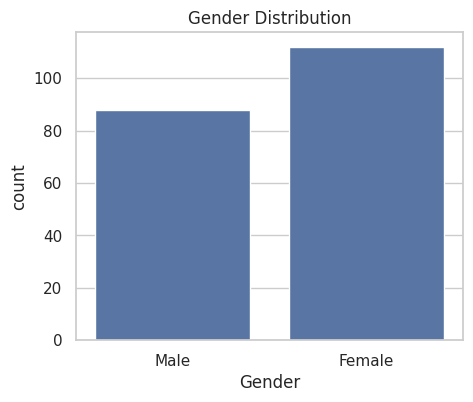

In [9]:
plt.figure(figsize=(5,4))
sns.countplot(x="Gender", data=df)
plt.title("Gender Distribution")
plt.show()

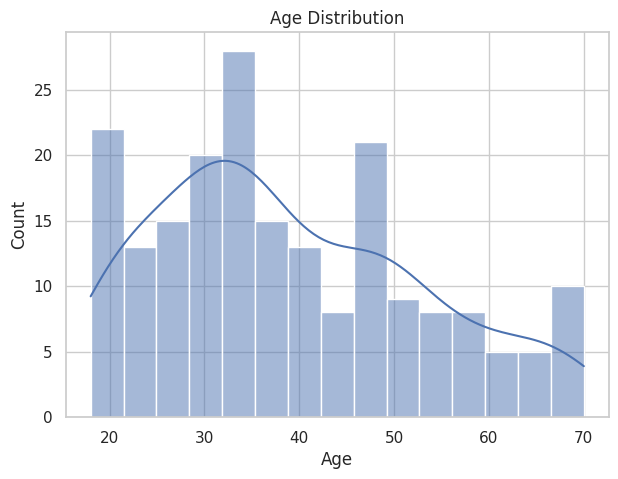

In [11]:
plt.figure(figsize=(7,5))
sns.histplot(df["Age"], bins=15, kde=True)
plt.title("Age Distribution")
plt.xlabel("Age")
plt.show()

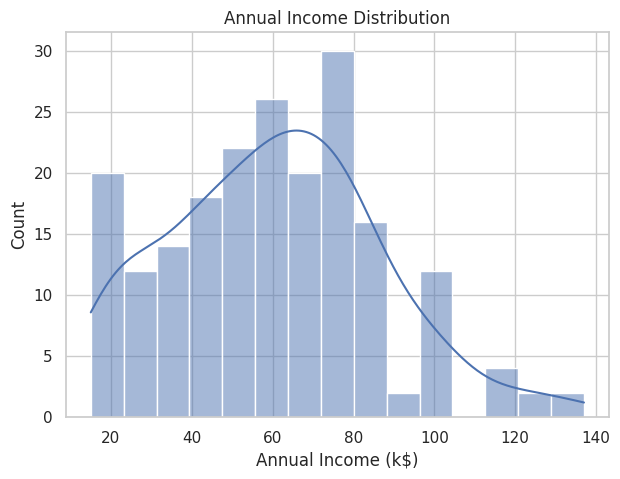

In [12]:
plt.figure(figsize=(7,5))
sns.histplot(df["Annual Income (k$)"], bins=15, kde=True)
plt.title("Annual Income Distribution")
plt.xlabel("Annual Income (k$)")
plt.show()

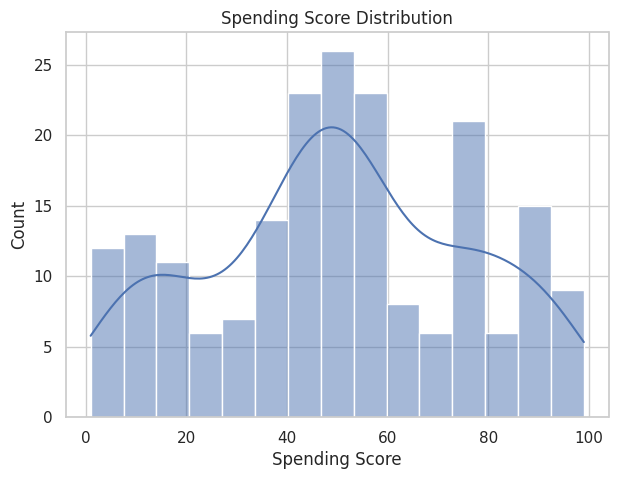

In [13]:
plt.figure(figsize=(7,5))
sns.histplot(df["Spending Score (1-100)"], bins=15, kde=True)
plt.title("Spending Score Distribution")
plt.xlabel("Spending Score")
plt.show()

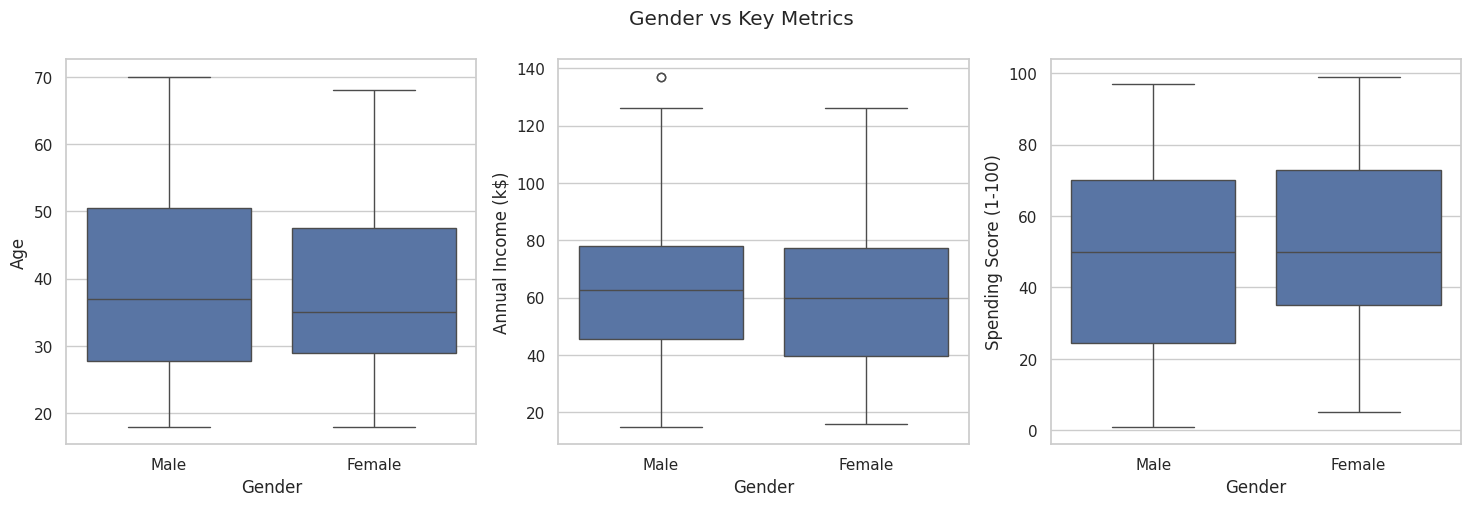

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(18,5))
sns.boxplot(x="Gender", y="Age", data=df, ax=axes[0])
sns.boxplot(x="Gender", y="Annual Income (k$)", data=df, ax=axes[1])
sns.boxplot(x="Gender", y="Spending Score (1-100)", data=df, ax=axes[2])
plt.suptitle("Gender vs Key Metrics")
plt.show()

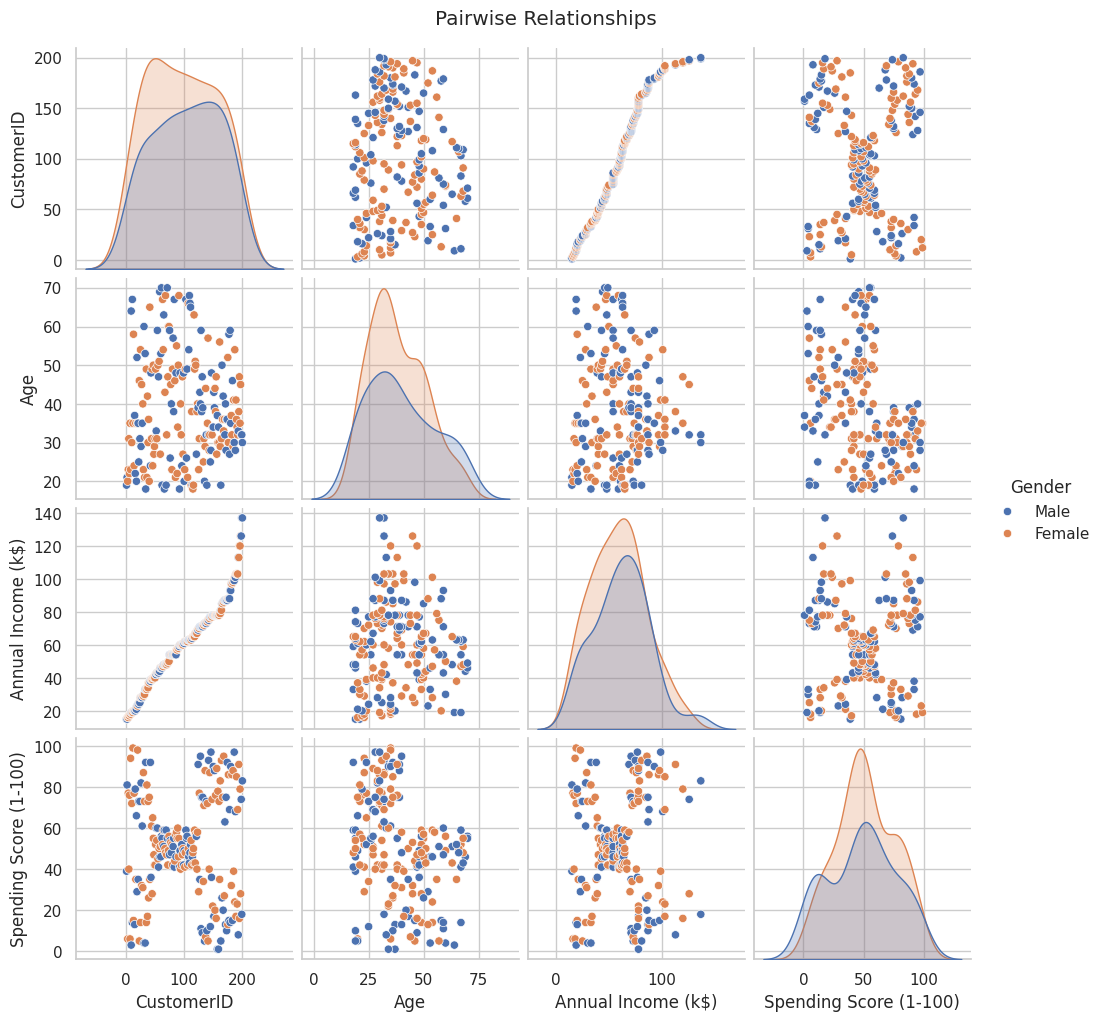

In [16]:
sns.pairplot(df, hue="Gender")
plt.suptitle("Pairwise Relationships", y=1.02)
plt.show()

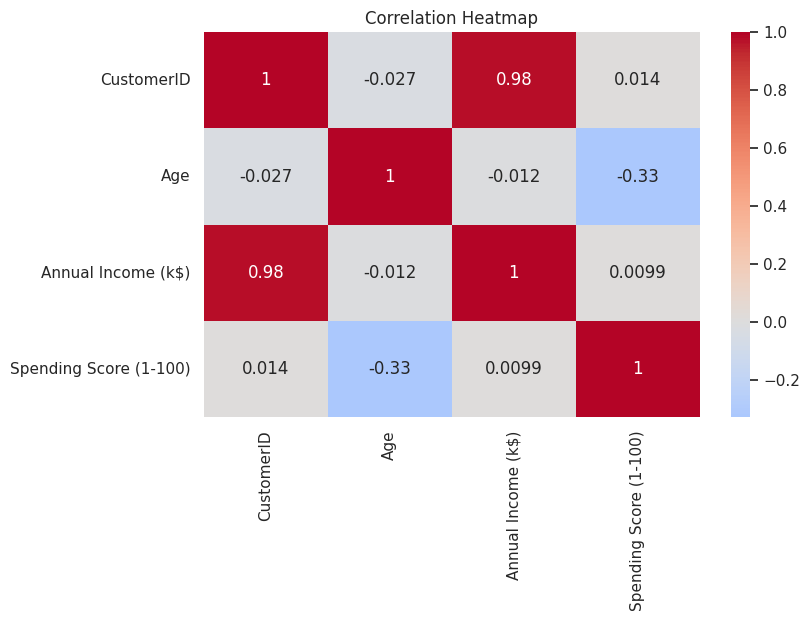

In [17]:
corr = df.corr(numeric_only=True)
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Heatmap")
plt.show()

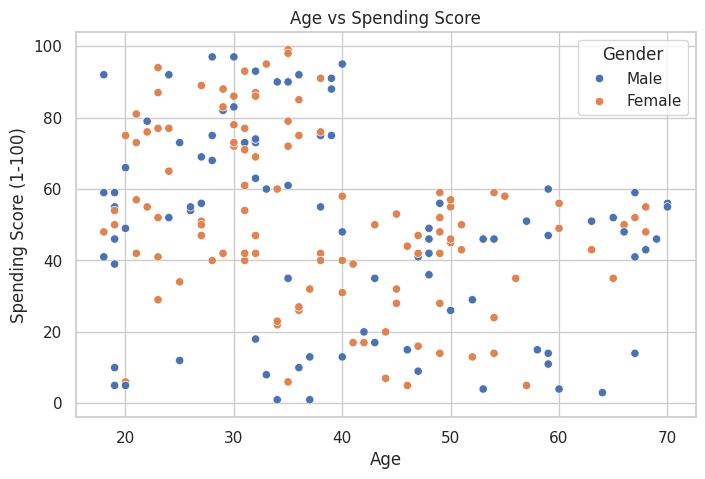

In [20]:
sns.scatterplot(x="Age", y="Spending Score (1-100)", hue="Gender", data=df)
plt.title("Age vs Spending Score")
plt.show()

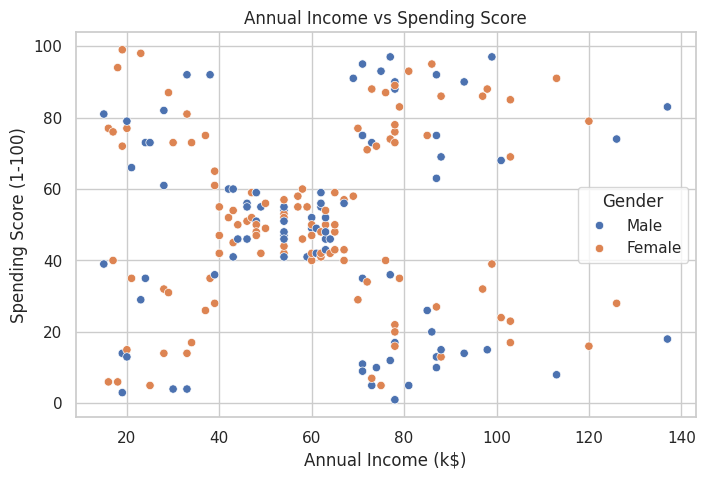

In [21]:
sns.scatterplot(x="Annual Income (k$)", y="Spending Score (1-100)", hue="Gender", data=df)
plt.title("Annual Income vs Spending Score")
plt.show()

In [22]:
X = df[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].values

In [24]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [25]:
print(df.describe())

       CustomerID         Age  Annual Income (k$)  Spending Score (1-100)
count  200.000000  200.000000          200.000000              200.000000
mean   100.500000   38.850000           60.560000               50.200000
std     57.879185   13.969007           26.264721               25.823522
min      1.000000   18.000000           15.000000                1.000000
25%     50.750000   28.750000           41.500000               34.750000
50%    100.500000   36.000000           61.500000               50.000000
75%    150.250000   49.000000           78.000000               73.000000
max    200.000000   70.000000          137.000000               99.000000


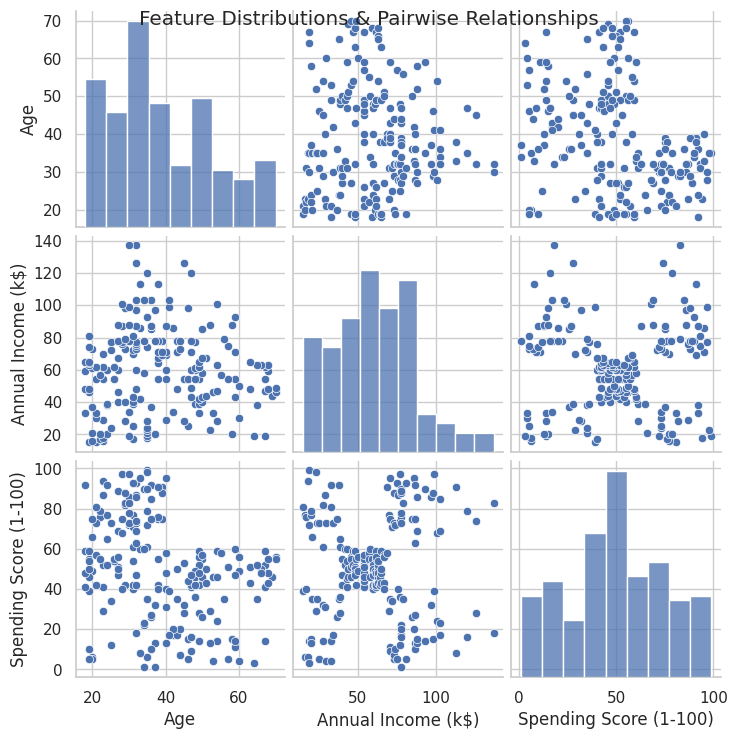

In [26]:
sns.pairplot(df[['Age','Annual Income (k$)','Spending Score (1-100)']])
plt.suptitle("Feature Distributions & Pairwise Relationships")
plt.show()

## Implementation of K-Means Algorithm

### 4. Implementing K-Means from Scratch

Below are the step-by-step implementations of K-Means components.

In [27]:
def initialize_centroids(X, k, random_state=None):
    if random_state:
        np.random.seed(random_state)
    indices = np.random.choice(X.shape[0], k, replace=False)
    return X[indices]


In [28]:
def initialize_centroids_kmeanspp(X, k, random_state=None):
    if random_state:
        np.random.seed(random_state)

    centroids = []
    centroids.append(X[np.random.randint(X.shape[0])])

    for _ in range(1, k):
        dist_sq = np.min([np.sum((X - c) ** 2, axis=1) for c in centroids], axis=0)
        probs = dist_sq / np.sum(dist_sq)
        cumulative_probs = np.cumsum(probs)
        r = np.random.rand()
        for j, p in enumerate(cumulative_probs):
            if r < p:
                centroids.append(X[j])
                break
    return np.array(centroids)


In [29]:
def assign_clusters(X, centroids):
    distances = np.linalg.norm(X[:, np.newaxis] - centroids, axis=2)
    return np.argmin(distances, axis=1)


In [30]:
def update_centroids(X, labels, k):
    new_centroids = np.array([X[labels == i].mean(axis=0) for i in range(k)])
    return new_centroids


In [31]:
def kmeans(X, k, max_iters=100, tol=1e-4, init='random', random_state=None):
    if init == 'kmeans++':
        centroids = initialize_centroids_kmeanspp(X, k, random_state)
    else:
        centroids = initialize_centroids(X, k, random_state)

    for i in range(max_iters):
        labels = assign_clusters(X, centroids)
        new_centroids = update_centroids(X, labels, k)
        shift = np.linalg.norm(new_centroids - centroids)
        if shift < tol:
            break
        centroids = new_centroids

    inertia = np.sum((X - centroids[labels])**2)
    return centroids, labels, i+1, inertia


### 5. Finding Optimal Number of Clusters

We use the Elbow Method and Silhouette Score to find the optimal number of clusters.

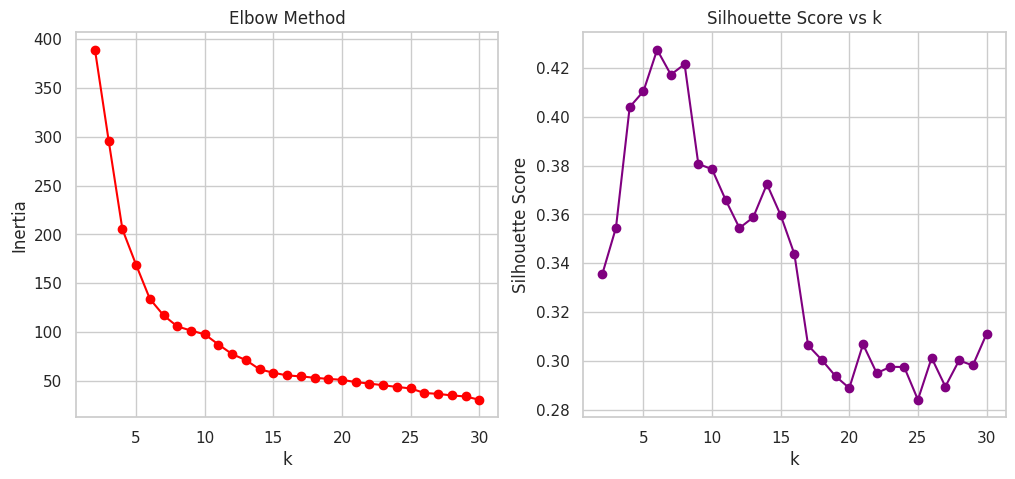

In [36]:
inertias = []
sil_scores = []
K = range(2, 31)

for k in K:
    centroids, labels, _, inertia = kmeans(X_scaled, k, init='kmeans++', random_state=42)
    inertias.append(inertia)
    sil_scores.append(silhouette_score(X_scaled, labels))

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(K, inertias, marker='o', color='red')
plt.title("Elbow Method")
plt.xlabel("k")
plt.ylabel("Inertia")

plt.subplot(1,2,2)
plt.plot(K, sil_scores, marker='o', color='purple')
plt.title("Silhouette Score vs k")
plt.xlabel("k")
plt.ylabel("Silhouette Score")

plt.show()

In [38]:
!pip install kneed

Optimal number of clusters (Elbow point): 7


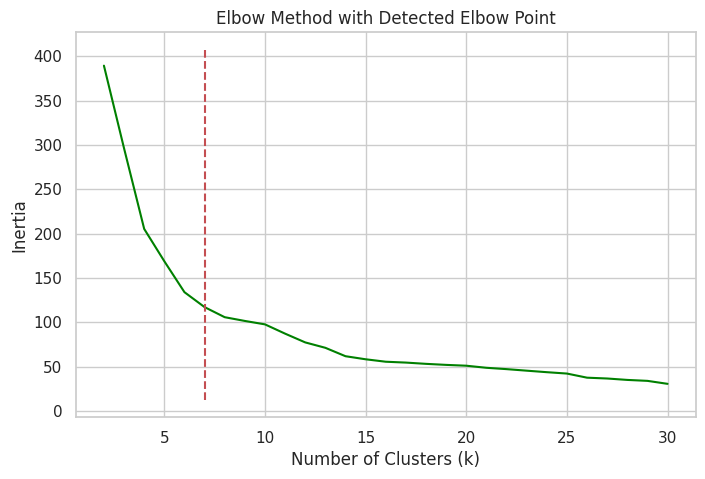

In [43]:
from kneed import KneeLocator

kneedle = KneeLocator(K, inertias, curve='convex', direction='decreasing')
optimal_k = kneedle.knee

print("Optimal number of clusters (Elbow point):", optimal_k)

plt.figure(figsize=(8,5))
plt.plot(K, inertias, color='green')
plt.vlines(optimal_k, plt.ylim()[0], plt.ylim()[1], linestyles='dashed', colors='r')
plt.title('Elbow Method with Detected Elbow Point')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.show()


### 6. Applying Custom K-Means Implementation

In [44]:
optimal_k = 7
centroids, labels, iters, inertia = kmeans(X_scaled, optimal_k, init='kmeans++', random_state=42)

print(f"Final Centroids (scaled):\n{centroids}")
print(f"Iterations: {iters}, Inertia: {inertia}")

df['Cluster'] = labels
print(df['Cluster'].value_counts())
print(df.groupby('Cluster')[['Age', 'Annual Income (k$)', 'Spending Score (1-100)']].mean())


Final Centroids (scaled):
[[ 1.86593393 -0.28283547 -0.01358755]
 [-0.44191719  0.99158305  1.23950275]
 [-0.97602698 -1.32549704  1.0371827 ]
 [ 0.20522958  1.12001418 -1.33646354]
 [-1.03882283 -0.14065435 -0.08904695]
 [ 0.61233873 -0.14037369 -0.12080356]
 [ 0.47007182 -1.33249477 -1.2287024 ]]
Iterations: 7, Inertia: 117.01155455889813
Cluster
1    39
5    34
4    32
3    31
2    24
0    20
6    20
Name: count, dtype: int64
               Age  Annual Income (k$)  Spending Score (1-100)
Cluster                                                       
0        64.850000           53.150000               49.850000
1        32.692308           86.538462               82.128205
2        25.250000           25.833333               76.916667
3        41.709677           89.903226               15.774194
4        24.375000           56.875000               47.906250
5        47.382353           56.882353               47.088235
6        45.400000           25.650000               18.550000


### 7. Visualization of Clusters

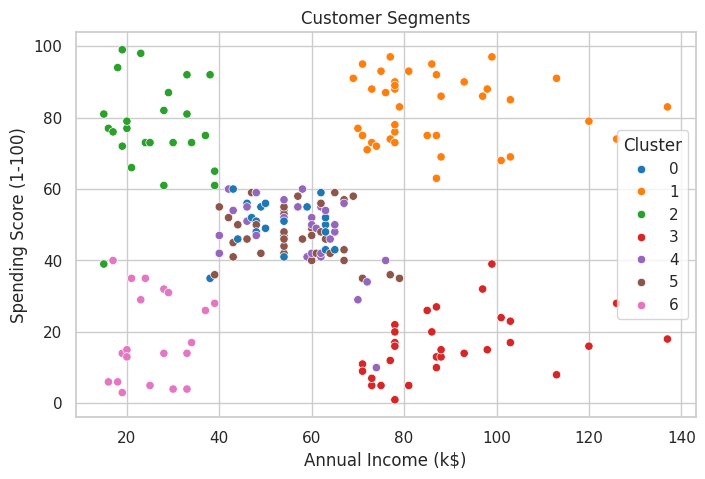

In [54]:
sns.scatterplot(data=df, x='Annual Income (k$)', y='Spending Score (1-100)', hue='Cluster', palette='tab10')
plt.title("Customer Segments")
plt.show()


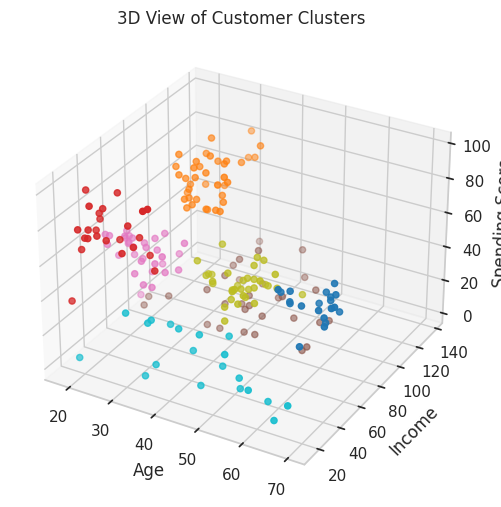

In [57]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['Age'], df['Annual Income (k$)'], df['Spending Score (1-100)'], c=df['Cluster'], cmap='tab10')
ax.set_xlabel('Age')
ax.set_ylabel('Income')
ax.set_zlabel('Spending Score')
plt.title("3D View of Customer Clusters")
plt.show()


### 8. Cluster Interpretation (Business Insights)

| Cluster | Interpretation |
|----------|----------------|
| 0 | Young, high-income, impulsive spenders |
| 1 | Older, low-income, conservative spenders |
| 2 | Middle-aged, wealthy but low-spending group |
| 3 | Moderate income, balanced spenders |
| 4 | Young, budget-friendly, frequent buyers |

### 9. Comparison with scikit-learn Implementation

In [61]:
import time

In [62]:
start = time.time()
sk_kmeans = SKKMeans(n_clusters=optimal_k, init='k-means++', random_state=42)
sk_kmeans.fit(X_scaled)
end = time.time()

print("scikit-learn K-Means Results")
print("----------------------------")
print(f"Iterations to Converge: {sk_kmeans.n_iter_}")
print(f"Inertia: {sk_kmeans.inertia_:.4f}")
print(f"Runtime: {end - start:.4f} seconds\n")

print("Final Centroids (Standardized Scale):")
print(pd.DataFrame(sk_kmeans.cluster_centers_,
                   columns=['Age','Annual Income (k$)','Spending Score (1-100)']))


scikit-learn K-Means Results
----------------------------
Iterations to Converge: 5
Inertia: 121.3894
Runtime: 0.0420 seconds

Final Centroids (Standardized Scale):
        Age  Annual Income (k$)  Spending Score (1-100)
0  1.255265           -0.261669               -0.031587
1 -0.441917            0.991583                1.239503
2 -0.993969           -1.347348                1.064048
3 -0.818539            0.640229               -1.539059
4  0.494526            1.168946               -1.173849
5  0.478957           -1.308230               -1.196444
6 -0.842677           -0.162705               -0.020355


In [63]:
comparison = pd.DataFrame({
    'Metric': ['Inertia', 'Iterations', 'Runtime (s)'],
    'Custom K-Means': [round(inertia, 4), iters, round(end - start, 4)],
    'scikit-learn KMeans': [round(sk_kmeans.inertia_, 4),
                            sk_kmeans.n_iter_,
                            round(end - start, 4)]
})
print(comparison)


        Metric  Custom K-Means  scikit-learn KMeans
0      Inertia        117.0116             121.3894
1   Iterations          7.0000               5.0000
2  Runtime (s)          0.0420               0.0420
